# IMMC 2020: With Variable Heuristic and Proper Product List
### Importing Modules and Data

In [55]:
import pandas as pd
import copy
import re
import random
import math, statistics
import numpy as np
import gc
import matplotlib.pyplot as plt
from pprint import pprint

median_income = 9733/365
loss_aversion_coefficient = 2
max_shelf_capacity = 150
crowd_avoidance = 0.5

pdt_csv_data = pd.read_csv("StoreData_IMMC_CSV.csv")
print(pdt_csv_data.head())

          department product_category       product_type     brand  \
0    TV&Home Theater   TVS 30" to 45"    1080p LED Smart  Brand BB   
1  Computers&Tablets          Laptops  2-in-1 Chromebook   Brand A   
2  Computers&Tablets          Laptops  2-in-1 Chromebook  Brand BB   
3  Computers&Tablets          Laptops  2-in-1 Chromebook   Brand G   
4  Computers&Tablets          Laptops  2-in-1 Chromebook   Brand P   

                                                name  initial_price  \
0                 40" 1080p Smart LED HDTV, 5 Series         259.99   
1  2-in-1 11.6" Touch-Screen Chromebook, Intel Ce...         279.99   
2  2-in-1 12.2" Touch-Screen Chromebook, Intel Ce...         449.00   
3  2-in-1 14" Touch-Screen Chromebook, Intel Core...         549.00   
4  2-in-1 14" Touch-Screen Chromebook, Intel Core...         599.00   

   discounted_price  qty  customer_rating  brand_rating  percentage_usage  \
0            179.99    8              4.7      4.623810              0.95  

In [56]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

## Determining the Popularity of Product
### Impact of Discount on Popularity

In [57]:
# Traditional Econs Approach
def q1_over_q0(p0, p1, percentage_usage):
    x = (p0 - p1)*(percentage_usage/median_income) 
    return (math.exp(x))

# Behavioural Econs Approach
def prospect_utility(x):
    if x > 0:
        return(math.log(x+1))
    else:
        return(-loss_aversion_coefficient * math.log(-x + 1))

def increase_utility(p0, p1):
    return(prospect_utility(p0 - p1))

# Helper Variables
max_increase_utility = increase_utility(3329.99, 2199.99)
min_increase_utility = 0
max_q1_over_q0 = q1_over_q0(3329.99, 2199.99, 1)
min_q1_over_qo = 1

# Combined Effect [Between 0 and 1]
def popularity_due_to_discount(p0, p1, percentage_usage):
    traditional_econs_adjusted = (q1_over_q0(p0, p1, percentage_usage)-min_q1_over_qo)/max_q1_over_q0
    behavioural_econs_adjusted = (increase_utility(p0, p1)-min_increase_utility)/max_increase_utility

    total_adjusted = statistics.mean([traditional_econs_adjusted, behavioural_econs_adjusted])
    return(total_adjusted)

### Effect of Loss Adversion on Popularity

In [58]:
# [Between 0 and 1]
def popularity_due_to_loss_aversion(qty):
    return(math.exp(-qty/loss_aversion_coefficient))

### Effects of Saliency Bias on Popularity (TO DO)

In [59]:
def popularity_due_to_saliency_bias(size, qty):
    return sigmoid(size*qty)

### Effects of Ratings on Popularity

In [60]:
# [Between 0 and 1]
def popularity_due_to_rating(pdt_rating, brand_rating):
    raw_brand = (0.8*pdt_rating + 0.2*brand_rating)
    return(raw_brand/5)

## Creating Product Class and List

In [61]:
class product:
    # Popularity Coefficients
    pop_loss_adversion_coefficient = 0.44
    pop_saliency_coefficient = 0.6
    pop_rating_coefficient = 0.5
    
    
    # Raw Data
    def __init__(self, index, name, department, product_category, product_type, brand, initial_price, discounted_price, qty, customer_rating, brand_rating=5, percentage_usage=0.5, size=20):
        self.name = name
        self.index = index
        self.department = department
        self.product_category = product_category
        self.product_type = product_type
        self.brand = brand
        self.initial_price = initial_price
        self.discounted_price = discounted_price
        self.qty = qty
        self.customer_rating = customer_rating
        self.brand_rating = brand_rating
        self.percentage_usage = percentage_usage
        self.size = size
        
        self.popularity = 0
    
    # Processed Data
    
    def set_popularity(self):
        discount_factor = popularity_due_to_discount(self.initial_price, self.discounted_price, self.percentage_usage)
        loss_adversion_factor = popularity_due_to_loss_aversion(self.qty)
        saliency_factor = popularity_due_to_saliency_bias(self.size, self.qty)
        rating_factor = popularity_due_to_rating(self.customer_rating, self.brand_rating)
        
        initial_popularity = self.pop_loss_adversion_coefficient*loss_adversion_factor + self.pop_saliency_coefficient*saliency_factor + self.pop_rating_coefficient*rating_factor
        self.popularity = sigmoid(initial_popularity + discount_factor)
        
        
        

In [62]:
# Populating the Product List
pdt_list = []
pdt_counter = 0
for index, row in pdt_csv_data.iterrows():
    
    total_qty = row["qty"]
    unit_size = row["index_size"]
    while True:
        
        cur_qty = min(min(int(max_shelf_capacity/unit_size), total_qty), 3)
        print("index", index, "department", row["department"], "qty", cur_qty, "net_size", cur_qty*unit_size)
        total_qty -= cur_qty
        
        cur_pdt = product(index, row["name"], row["department"], row["product_category"], row["product_type"], row["brand"], row["initial_price"], row["discounted_price"], cur_qty, row["customer_rating"], size=unit_size, brand_rating=row["brand_rating"], percentage_usage=row["percentage_usage"])
        cur_pdt.set_popularity()
        
        pdt_counter += 1
        pdt_list.append(cur_pdt)
        
        if total_qty <=0:
            break

print("pdt_list len", len(pdt_list))
print("Number of products", pdt_counter)

index 0 department TV&Home Theater qty 3 net_size 6.038068754999999
index 0 department TV&Home Theater qty 3 net_size 6.038068754999999
index 0 department TV&Home Theater qty 2 net_size 4.02537917
index 1 department Computers&Tablets qty 3 net_size 0.3252653034
index 1 department Computers&Tablets qty 3 net_size 0.3252653034
index 1 department Computers&Tablets qty 3 net_size 0.3252653034
index 1 department Computers&Tablets qty 1 net_size 0.1084217678
index 2 department Computers&Tablets qty 3 net_size 0.3252653034
index 2 department Computers&Tablets qty 3 net_size 0.3252653034
index 2 department Computers&Tablets qty 2 net_size 0.2168435356
index 3 department Computers&Tablets qty 3 net_size 0.3252653034
index 3 department Computers&Tablets qty 3 net_size 0.3252653034
index 3 department Computers&Tablets qty 3 net_size 0.3252653034
index 3 department Computers&Tablets qty 1 net_size 0.1084217678
index 4 department Computers&Tablets qty 3 net_size 0.3252653034
index 4 department Comp

index 39 department Computers&Tablets qty 3 net_size 2.6665274229
index 39 department Computers&Tablets qty 3 net_size 2.6665274229
index 39 department Computers&Tablets qty 3 net_size 2.6665274229
index 39 department Computers&Tablets qty 3 net_size 2.6665274229
index 39 department Computers&Tablets qty 3 net_size 2.6665274229
index 40 department Computers&Tablets qty 3 net_size 2.6665274229
index 40 department Computers&Tablets qty 3 net_size 2.6665274229
index 40 department Computers&Tablets qty 3 net_size 2.6665274229
index 40 department Computers&Tablets qty 3 net_size 2.6665274229
index 40 department Computers&Tablets qty 3 net_size 2.6665274229
index 41 department Computers&Tablets qty 3 net_size 2.6665274229
index 41 department Computers&Tablets qty 3 net_size 2.6665274229
index 41 department Computers&Tablets qty 3 net_size 2.6665274229
index 41 department Computers&Tablets qty 3 net_size 2.6665274229
index 41 department Computers&Tablets qty 3 net_size 2.6665274229
index 42 d

index 86 department Video Gaming qty 3 net_size 0.4283993235
index 87 department Cell Phones qty 3 net_size 0.024660862218000002
index 87 department Cell Phones qty 3 net_size 0.024660862218000002
index 87 department Cell Phones qty 3 net_size 0.024660862218000002
index 87 department Cell Phones qty 3 net_size 0.024660862218000002
index 87 department Cell Phones qty 3 net_size 0.024660862218000002
index 88 department Cell Phones qty 3 net_size 0.024660862218000002
index 88 department Cell Phones qty 3 net_size 0.024660862218000002
index 88 department Cell Phones qty 3 net_size 0.024660862218000002
index 88 department Cell Phones qty 3 net_size 0.024660862218000002
index 88 department Cell Phones qty 3 net_size 0.024660862218000002
index 88 department Cell Phones qty 3 net_size 0.024660862218000002
index 88 department Cell Phones qty 2 net_size 0.016440574812
index 89 department Cell Phones qty 3 net_size 0.024660862218000002
index 89 department Cell Phones qty 3 net_size 0.024660862218

In [63]:
department_popularities = {
    "Appliances": 0,
    "Audio": 0,
    "Cameras": 0,
    "Cell Phones": 0,
    "Computers&Tablets": 0,
    "TV&Home Theater": 0,
    "Video Gaming": 0
}
department_qty = {
    "Appliances": 0,
    "Audio": 0,
    "Cameras": 0,
    "Cell Phones": 0,
    "Computers&Tablets": 0,
    "TV&Home Theater": 0,
    "Video Gaming": 0
}
for pdt in pdt_list:
    department_popularities[pdt.department]+= pdt.popularity*pdt.qty
    department_qty[pdt.department]+= pdt.qty

for department, total_pop in department_popularities.items():
    print("Department:", department, "Average Popularity", total_pop/department_qty[department])
    
    
print("--------")
total_objects = 0
for department, total_pop in department_popularities.items():
    number_of_objects = 0
    for pdt in pdt_list:
        if pdt.department == department:
            number_of_objects += 1
    total_objects += number_of_objects
    print("Department:", department, "Number of Objects", number_of_objects)
    
print("Total Number of Objects", total_objects)

Department: Appliances Average Popularity 0.8237294457073325
Department: Audio Average Popularity 0.7633075738636679
Department: Cameras Average Popularity 0.778664491286548
Department: Cell Phones Average Popularity 0.7508801032730387
Department: Computers&Tablets Average Popularity 0.7983702881702469
Department: TV&Home Theater Average Popularity 0.8136857291830653
Department: Video Gaming Average Popularity 0.8130530077308477
--------
Department: Appliances Number of Objects 119
Department: Audio Number of Objects 18
Department: Cameras Number of Objects 59
Department: Cell Phones Number of Objects 19
Department: Computers&Tablets Number of Objects 159
Department: TV&Home Theater Number of Objects 134
Department: Video Gaming Number of Objects 62
Total Number of Objects 570


In [64]:
pdt_list[4].index

1

## Creating Shelf Class and Layout Object

In [65]:
class shelf:
    # Class Variables
    
    def __init__(self, department):
        self.pdts = []
        self.pdt_set = set()
        self.department = department
        self.cur_capacity = 0
    
    def add_pdt(self, pdt):
        # Check Department
        # print("Adding Product")
        # print("  product_department", pdt.department)
        # print("  shelf_department", self.department)
        if pdt.department != self.department:
            return -1
        
        # If shelf can accomodate the product
        if self.cur_capacity + pdt.size*pdt.qty <= max_shelf_capacity:
            self.cur_capacity += pdt.size*pdt.qty
            self.pdts.append(pdt)
            self.pdt_set.add(pdt.index)
            return 0
        
        # If shelf is full
        return -1

In [93]:
class layout:
    
    def __init__(self, grid, counter, entrance, exit, shelf_list=[], pdt_list=[]):
        self.counter = counter
        self.value_of_goods_bought = 0
        self.shopper_size = 0
        self.entrance = entrance
        self.exit = exit
        
        # Grid is a 2d matrix where shelves are 1 indexed
        self.grid = copy.deepcopy(grid)
        self.shelf_list = copy.deepcopy(shelf_list)
        
        # A* Grid is a grid where shelves are labelled as 1
        self.a_star_grid = copy.deepcopy(grid)
        for i in range(len(self.a_star_grid)):
            for j in range(len(self.a_star_grid)):
                if self.a_star_grid[i][j] > 1:
                    self.a_star_grid[i][j] = 1
                    
        # Shopper Density Grid is a grid to record the density of shoppers; shelves have a density of 99
        self.shopper_density_grid = copy.deepcopy(self.a_star_grid)
        for i in range(len(self.shopper_density_grid)):
            for j in range(len(self.shopper_density_grid)):
                if self.shopper_density_grid[i][j] == 1:
                    self.shopper_density_grid[i][j] = -1
                    
        # Price Density Grid is a grid to record to value of products the customers are carrying at particular locations
        self.price_density_grid = copy.deepcopy(grid)
        for i in range(len(self.price_density_grid)):
            for j in range(len(self.price_density_grid)):
                if self.price_density_grid[i][j] > 0:
                    self.price_density_grid[i][j] = 0
                    
                    
        # pdt_list contains the products that exists somewhere within the layout
        self.pdt_list = copy.deepcopy(pdt_list)
        
        
        
    # A_Star Performs a simulation of a person walking within the layout from init to goal
    # A_Star Returns a list of nodes visited on the path
    # Coordinates are written as [y,x] with [0,0] being the upper left hand corner
    def a_star(self, init, goal): 
        grid = copy.deepcopy(self.a_star_grid)
        cost = 1

        # the cost map which pushes the path closer to the goal
#         heuristic = [[0 for row in range(len(grid[0]))] for col in range(len(grid))]
#         for i in range(len(grid)):
#             for j in range(len(grid[0])):
#                 heuristic[i][j] = abs(i - goal[0]) + abs(j - goal[1])
#                 if grid[i][j] == 1:
#                     heuristic[i][j] = 99  # added extra penalty in the heuristic map

        heuristic = [[0 for row in range(len(grid[0]))] for col in range(len(grid))]
        for i in range(len(grid)):
            for j in range(len(grid[0])):
                heuristic[i][j] = abs(i - goal[0]) + abs(j - goal[1])
                if grid[i][j] == 1:
                    heuristic[i][j] = 999999  # added extra penalty in the heuristic map
                else:
                    heuristic[i][j] = crowd_avoidance * self.shopper_density_grid[i][j]



        # the actions we can take
        delta = [[-1, 0], [0, -1], [1, 0], [0, 1]]  # go up  # go left  # go down  # go right


        # function to search the path
        def search(grid, init, goal, cost, heuristic):

            closed = [
                [0 for col in range(len(grid[0]))] for row in range(len(grid))
            ]  # the reference grid
            closed[init[0]][init[1]] = 1
            action = [
                [0 for col in range(len(grid[0]))] for row in range(len(grid))
            ]  # the action grid

            x = init[0]
            y = init[1]
            g = 0
            f = g + heuristic[init[0]][init[0]]
            cell = [[f, g, x, y]]

            found = False  # flag that is set when search is complete
            resign = False  # flag set if we can't find expand

            while not found and not resign:
                if len(cell) == 0:
                    return "FAIL"
                else:
                    cell.sort()  # to choose the least costliest action so as to move closer to the goal
                    cell.reverse()
                    next = cell.pop()
                    x = next[2]
                    y = next[3]
                    g = next[1]

                    if x == goal[0] and y == goal[1]:
                        found = True
                    else:
                        for i in range(len(delta)):  # to try out different valid actions
                            x2 = x + delta[i][0]
                            y2 = y + delta[i][1]
                            if x2 >= 0 and x2 < len(grid) and y2 >= 0 and y2 < len(grid[0]):
                                if closed[x2][y2] == 0 and grid[x2][y2] == 0:
                                    g2 = g + cost
                                    f2 = g2 + heuristic[x2][y2]
                                    cell.append([f2, g2, x2, y2])
                                    closed[x2][y2] = 1
                                    action[x2][y2] = i
            invpath = []
            x = goal[0]
            y = goal[1]
            invpath.append([x, y])  # we get the reverse path from here
            while x != init[0] or y != init[1]:
                x2 = x - delta[action[x][y]][0]
                y2 = y - delta[action[x][y]][1]
                x = x2
                y = y2
                invpath.append([x, y])

            path = []
            for i in range(len(invpath)):
                path.append(invpath[len(invpath) - 1 - i])
                
#             print("ACTION MAP")
#             for i in range(len(action)):
#                 print(action[i])

            return path
        return search(grid, init, goal, cost, heuristic)
    
    # Simulates Choice of Object to Buy and Deletes that Object from Object List
    def choose_pdt(self):
        if len(self.pdt_list) == 0:
            print("RAN OUT OF ITEMS IN SHOP")
            return -1
        self.pdt_list.sort(key=lambda x: x.popularity, reverse=True)
        index = min(random.randint(0, 5), len(self.pdt_list) -1)
        chosen_pdt = copy.deepcopy(self.pdt_list[index])
        return chosen_pdt
    
    def delete_pdt(self, product_index):
        for i in range(len(self.pdt_list)):
            if self.pdt_list[i].index == product_index:
                print("deleting pdt from list", product_index)
                
                if self.pdt_list[i].qty == 1:
                    self.pdt_list.pop(i)
                else:
                    self.pdt_list[i].qty -= 1
                    
                break
        
        return
    
    # Find Product in Sheleves
    def find_shelf(self, chosen_pdt_index):
        for shelf_index, shelf in enumerate(self.shelf_list):
                # print("Checking shelf", shelf_index)
                if chosen_pdt_index in shelf.pdt_set:
                    chosen_shelf_index = shelf_index
        return chosen_shelf_index
    
    def delete_pdt_from_shelf(self, chosen_pdt_index, shelf_index):
        # Remove product from shelf
        shelf = self.shelf_list[shelf_index]
        for i in range(len(shelf.pdts)):
            if shelf.pdts[i].index == chosen_pdt_index:
                # print("QTY of pdt", shelf.pdts[i].qty)
                    if shelf.pdts[i].qty <= 1:
                        print("ran out of product", chosen_pdt_index)
                        del shelf.pdts[i]
                        
                    else:
                        shelf.pdts[i].qty-= 1
                        shelf.pdts[i].set_popularity()
                    break
        
        last_product_of_type = True
        for j in range(len(shelf.pdts)):
            if shelf.pdts[j].index == chosen_pdt_index:
                last_product_of_type = False
                # print("##@@##@###@###@#####@#@#@###@##Meow")
                break
        if last_product_of_type:
            shelf.pdt_set.discard(chosen_pdt_index)
        return
            
                        
        
    def walk(self, init, goal, cur_size, cur_price):
        # Conduct A*
        delta = [(1,0), (-1,0), (0,1), (0,-1)]
        for d in delta:
            y = goal[0]+d[0]
            x = goal[1]+d[1]
            if x >= 0 and x < len(self.grid) and y >= 0 and y < len(self.grid[0]):
                if goal == self.exit:
                    [y,x] = [goal[0], goal[1]]
                path = self.a_star(init, [y,x])
                if path == "FAIL":
                    z=0
                else:
                    for cell in path:
                        self.shopper_density_grid[cell[0]][cell[1]] += cur_size
                        self.price_density_grid[cell[0]][cell[1]] += cur_price
                    cur_pos = [y,x]
                    print("Visited ", y, x)
                    return cur_pos
        
    # Simulates a person entering shop
    def new_shopper(self):
        print("--Testing New Shopper--")
        max_number_of_products = 3
        max_size = 300
        
        cur_number_of_pdt = 0
        cur_size = random.randint(40, 60)
        cur_price = 0
        
        print("Size of Shopper:", cur_size)
        
        # Random Entrance Square
        cur_pos = random.choice(self.entrance)
        
        if len(self.pdt_list) == 0:
            return -1
        while cur_size < max_size and cur_number_of_pdt < 3 and len(self.pdt_list) > 0:
            
            # Choose what Product to Buy
            chosen_pdt = self.choose_pdt()
            if cur_size + chosen_pdt.size > max_size:
                print("next pdt too heavy")
                break
            
            print("Chosen Product:", chosen_pdt.index)
        
            # Find Shelf Index
            chosen_shelf_index = self.find_shelf(chosen_pdt.index)
            print("Shelf Containing Product:", chosen_shelf_index)
        
            # Find Location of Shelf 
            for y in range(len(self.grid)):
                for x in range(len(self.grid[0])):
                    if self.grid[y][x] == chosen_shelf_index:
                        shelf_location = (y,x)
    
            # Walk from cur_pos to another shelf while tracking the movement of the shopper
            cur_pos = self.walk(cur_pos, shelf_location, cur_size, cur_price)
            self.delete_pdt(chosen_pdt.index)
            self.delete_pdt_from_shelf(chosen_pdt.index, chosen_shelf_index)
            self.value_of_goods_bought += chosen_pdt.discounted_price
            cur_number_of_pdt +=1
            cur_price += chosen_pdt.discounted_price
            cur_size += chosen_pdt.size
        
        # Walk to Counter
        cur_pos = self.walk(cur_pos, random.choice(self.counter), cur_size, cur_price)
        cur_pos = self.walk(cur_pos, random.choice(self.exit), cur_size, 0)
        
        self.shopper_size += cur_size
        
        print("--Finishing Shopper--")
                
        return 0
        
    # Get adjusted Price Grid
    def get_price_grid(self):
        total_price = 0
        for i in range(len(self.price_density_grid)):
            for j in range(len(self.price_density_grid)):
                total_price += self.price_density_grid[i][j]
        
        adjusted_grid = copy.deepcopy(self.price_density_grid)
        for i in range(len(self.price_density_grid)):
            for j in range(len(self.price_density_grid)):
                adjusted_grid[i][j] *= (self.value_of_goods_bought/total_price)
                adjusted_grid[i][j] = int(adjusted_grid[i][j])
        
        return adjusted_grid
    
    def get_shopper_grid(self):
        total_size = 0
        for i in range(len(self.shopper_density_grid)):
            for j in range(len(self.shopper_density_grid)):
                total_size += self.shopper_density_grid[i][j]
        
        adjusted_grid = copy.deepcopy(self.shopper_density_grid)
        for i in range(len(self.shopper_density_grid)):
            for j in range(len(self.shopper_density_grid)):
                adjusted_grid[i][j] *= (self.shopper_size/total_size)
                adjusted_grid[i][j] = int(adjusted_grid[i][j])
        
        return adjusted_grid
    
    # Collision Damage / Self-Drops
    def loss(self, shopper_density, price_density):
        p_collision = (min(shopper_density, 300)) **2 / (300*300)
        return p_collision*price_density

    def total_loss(self):
        shopper_density_grid = self.get_shopper_grid()
        price_density_grid = self.get_price_grid()
        
        net_loss = 0
        for y in range(len(shopper_density_grid)):
            for x in range(len(shopper_density_grid)):
                net_loss += self.loss(shopper_density_grid[y][x], price_density_grid[y][x])

        return net_loss


QTY of pdt1 3
QTY of pdt2 3
total_value 1079.94
--Testing New Shopper--
Size of Shopper: 54
Chosen Product: 0
Shelf Containing Product: 2
Visited  0 5
deleting pdt from list 0
Chosen Product: 0
Shelf Containing Product: 2
Visited  0 5
deleting pdt from list 0
Chosen Product: 0
Shelf Containing Product: 2
Visited  0 5
deleting pdt from list 0
ran out of product 0
Visited  6 0
Visited  7 6
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 46
Chosen Product: 0
Shelf Containing Product: 1
Visited  0 2
deleting pdt from list 0
Chosen Product: 0
Shelf Containing Product: 1
Visited  0 2
deleting pdt from list 0
Chosen Product: 0
Shelf Containing Product: 1
Visited  0 2
deleting pdt from list 0
ran out of product 0
Visited  6 0
Visited  7 6
--Finishing Shopper--
--Testing New Shopper--
Size of Shopper: 41
---- Price Grid ----
[[93, 93, 140, 46, 46, 93, 0, 0],
 [93, 0, 0, 0, 0, 0, 0, 0],
 [93, 0, 0, 0, 0, 0, 0, 0],
 [93, 0, 0, 0, 0, 0, 0, 0],
 [93, 0, 0, 0, 0, 0, 0, 0],
 [93, 0, 0,

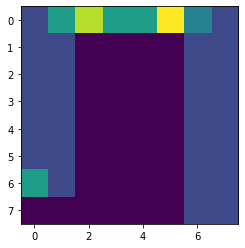

In [94]:
## Testing the Layout Object
example_layout_grid = [
    [0,0,0,0,0,0,0,0],
    [0,0,1,0,0,2,0,0],
    [0,0,3,0,0,4,0,0],
    [0,0,11,0,0,6,0,0],
    [0,0,12,0,0,7,0,0],
    [0,0,13,0,0,8,0,0],
    [0,0,14,0,0,9,0,0],
    [0,0,15,0,0,10,0,0]
]

pdt_1 = copy.deepcopy(pdt_list[0])
pdt_2 = copy.deepcopy(pdt_list[1])

print("QTY of pdt1", pdt_1.qty)
print("QTY of pdt2", pdt_2.qty)

total_value = pdt_1.qty*pdt_1.discounted_price + pdt_2.qty*pdt_2.discounted_price
print("total_value", total_value)

shelf_0 = shelf("")
shelf_1 = shelf(pdt_1.department)
shelf_2 = shelf(pdt_2.department)

shelf_1.add_pdt(pdt_1)
shelf_2.add_pdt(pdt_2)

counter = [(7,0)]
entrance = [[7,7]]
exit = [[8,6]]
test_layout = layout(example_layout_grid, counter, entrance, exit, [shelf_0, shelf_1, shelf_2], [pdt_1, pdt_2])

shopper_density_grid = test_layout.new_shopper()
shopper_density_grid = test_layout.new_shopper()
shopper_density_grid = test_layout.new_shopper()

shopper_density_grid = test_layout.get_shopper_grid()

price_density_grid = test_layout.get_price_grid()

plt.imshow(shopper_density_grid)
print("---- Price Grid ----")
pprint(price_density_grid)

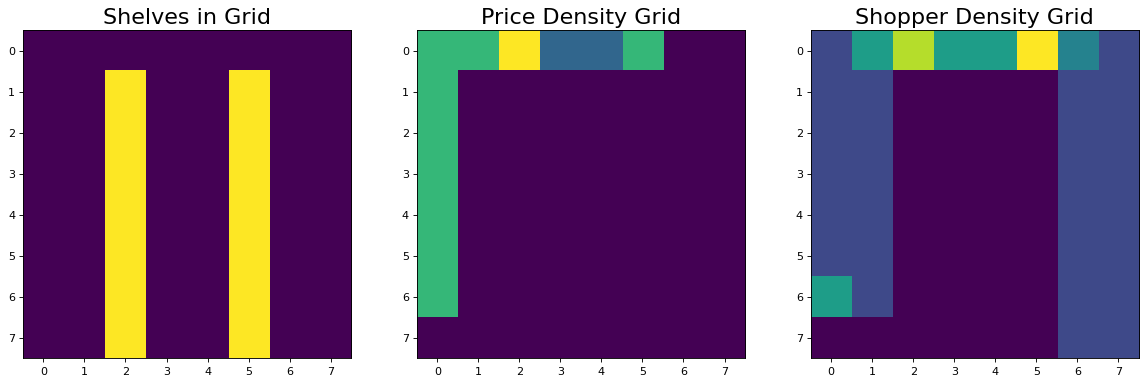

<Figure size 90000x90000 with 0 Axes>

In [95]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(1, 3, 1)
plt.title("Shelves in Grid",fontsize=20)
plt.imshow(test_layout.a_star_grid)
plt.subplot(1, 3, 2)
plt.title("Price Density Grid",fontsize=20)
plt.imshow(price_density_grid)
plt.subplot(1, 3, 3)
plt.title("Shopper Density Grid",fontsize=20)
plt.imshow(shopper_density_grid)


plt.figure(num=None, figsize=(100, 100), dpi=900, facecolor='w', edgecolor='k')
plt.show()

## Simulate Layout in Figure 1
### Create and Process Layout

In [ ]:
def split_row(word): 
    return [char for char in word]  

In [ ]:
fig_1_layout =r'''
000cccccccccc00000cccccccccc0000cccccccccc00000c
00000000000000000000000000000000000000000000000c
d0000000000000000000000000000000000000000000000c
d00000000000000000000000000000000000000000bbb00c
d00000000000000000000000000000000000000000bbb00c
d00ddd00ggg00ggg00e000e000e000e000e0000000bbb00c
d00ddd00ggg00ggg00ee00ee00ee00ee00ee000000bbb00c
d00ddd00ggg00ggg00ee00ee00ee00ee00ee000000bbb00c
d000000000000000000ee00ee00ee00ee00ee0000000000c
d000000000000000000ee00ee00ee00ee00ee0000000000c

d00ddd00ggg00ggg00000000000000000000000000bbb00c
d00ddd00ggg00ggg0000eeeee00eeeee00eeeee000bbb00c
d00ddd00ggg00ggg0000eeeee00eeeee00eeeee000bbb00c
d00000000000000000000000000000000000000000bbb00c
d00000000000000000000000000000000000000000bbb00c
d00ddd00ggg00ggg0000eeeee00eeeee00eeeee000bbb00c
d00ddd00ggg00ggg0000eeeee00eeeee00eeeee000bbb00c
d00ddd00ggg00ggg00000000000000000000000000bbb00c
d00000000000000000000000000000000000000000bbb00c
d00000000000000000000000000000000000000000bbb00c

d00000000000000000000000000000000000000000bbb00c
d00000000000000000000000000000000000000000bbb00c
d0ff0ff0ff0ff0ff00000aa00aaaaaaaaaa00aa000bbb00c
d0ff0ff0ff0ff0ff00000aa00aaaaaaaaaa00aa00000000c
d0ff0ff0ff0ff0ff0000000000000000000000000000000c
d0ff0ff0ff0ff0ff00000000000000000000000000bbb00c
d0ff0ff0ff0ff0ff00000aa00aaaaaaaaaa00aa000bbb00c
d0ff0ff0ff0ff0ff00000aa00aaaaaaaaaa00aa000bbb00c
d0ff0ff0ff0ff0ff00000000000000000000000000bbb00c
d0ff0ff0ff0ff0ff00000000000000000000000000bbb00c

d0ff0ff0ff0ff0ff00000aa00aaaaaaaaaa00aa000bbb00c
d0ff0ff0ff0ff0ff00000aa00aaaaaaaaaa00aa000bbb00c
d0ff0ff0ff0ff0ff00000000000000000000000000bbb00c
d00000000000000000000aa00aaaa00aaa00aaa000bbb00c
d00000000000000000000aa00aaaa00aaa00aaa000bbb00c
d0000000000000000000000000000000000000000000000c
d00000000000000000000000000000000000000000bbb00c
d00000000000000000000000000000000000000000bbb00c
000000000000000000000000000000000000000000bbb00c
000000000000000000000000000000000000000000bbb00c

000000000000000000000000000000000000000000bbb00c
000000000000000000000000000000000000000000bbb00c
000000000000000000000000000000000000000000bbb00c
000000000000000000000000000000000000000000bbb00c
000000000000000000000000000000000000000000bbb00c
000000000000000000000000000000000000000000bbb000
000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000
'''
fig_1_layout = fig_1_layout.replace('\n\n', '\n')
fig_1_layout = fig_1_layout.strip("\n")

fig_1_layout = fig_1_layout.split("\n")
for i in range(len(fig_1_layout)):
    fig_1_layout[i] = split_row(fig_1_layout[i])

In [ ]:
department_dictionary = {
    "a": "Appliances",
    "b": "Audio",
    "c": "Cameras",
    "d": "Cell Phones",
    "e": "Computers&Tablets",
    "f": "TV&Home Theater",
    "g": "Video Gaming",
}
shelf_list = [shelf("")]
shelf_counter = 1
for (letter, department_name) in department_dictionary.items():
    for y in range(len(fig_1_layout)):
        for x in range(len(fig_1_layout)):
            if str(fig_1_layout[y][x]) == letter:
                print("found shelf", shelf_counter, "department:", department_name)
                fig_1_layout[y][x] = str(shelf_counter)
                shelf_counter += 1
                shelf_list.append(shelf(department_name))

for y in range(len(fig_1_layout)):
    for x in range(len(fig_1_layout)):
        if not str(fig_1_layout[y][x]).isdigit():
            fig_1_layout[y][x] = str(shelf_counter)
            shelf_counter +=1
        fig_1_layout[y][x] = int(fig_1_layout[y][x])
        
        
    
max_shelf_index = shelf_counter

### Process Objects Based on Department to Place into Shelves

In [ ]:
max_pdt_per_shelf = 3

pdt_index = 0
pdt_list.sort(key=lambda x: x.department)

for shelf_index in range(1, max_shelf_index):
    print("\nShelf Index: ", shelf_index)
    cur_shelf = shelf_list[shelf_index]
    print("Shelf Department -- ", cur_shelf.department)
    
    for i in range(max_pdt_per_shelf):
        next_pdt = copy.deepcopy(pdt_list[pdt_index])
        print("Products Department", next_pdt.department)
        if cur_shelf.add_pdt(next_pdt) != -1:
            print("Added pdt id", next_pdt.index)
            pdt_index += 1
            if pdt_index == len(pdt_list):
                break
        else:
            break
    print("Products in shelf" , shelf_index, ":", cur_shelf.pdt_set)

    if pdt_index == len(pdt_list):
        print("--- Finished All Products with", shelf_index, "out of", max_shelf_index, "shelves --- ")
        break

### Run Simulation of Shoppers

In [ ]:
## Test Layout with Model
import gc
counters = [(40, 6),(40, 7),(40, 8),(40, 9),(40, 10), (40, 11), (40,12), (40,13)]
# counters = [(24, 24),(24, 25),(24, 26),(24, 23),(24, 22)]
entrances = [[47,30],[47,29],[47,28]]
exit = [[48,35],[48,36],[48,37]]
fig_1_layout_object = layout(fig_1_layout, counters, entrances, exit, shelf_list, pdt_list)
print("Number of products in layout:", len(fig_1_layout_object.pdt_list))

In [ ]:
fig_1_layout_object.new_shopper()

In [ ]:
gc.collect()
for i in range(600):
    try:
        shopper_density_grid = fig_1_layout_object.new_shopper()
        if shopper_density_grid == -1:
            print("Exhausted Shop with approximately", i, "shoppers")
            break
    except:
        pass
price_density_grid = fig_1_layout_object.get_price_grid()
shopper_density_grid = fig_1_layout_object.get_shopper_grid()

In [ ]:
plt.imshow(price_density_grid)
plt.title("Price Density Grid")
plt.show()

plt.imshow(shopper_density_grid)
plt.title("Shopper Density Grid")
plt.show()

### Analysis of Crowd Density

In [ ]:
total=0
for pdt in pdt_list:
    total += pdt.discounted_price*pdt.qty
    
print("No of products:", len(pdt_list))
print("Number of products in layout:", len(fig_1_layout_object.pdt_list))
print("Total Value", total)
print("Value of Goods bought",fig_1_layout_object.value_of_goods_bought )
print("Total Loss:", fig_1_layout_object.total_loss())

In [ ]:
print("Standard Deviation of Shopper Density:", np.std(shopper_density_grid, axis=(0,1)))
print("Standard Deviation of Price Density:", np.std(price_density_grid, axis=(0,1)))

### Debugging Cells

In [ ]:
for pdt in fig_1_layout_object.pdt_list:
    print(pdt.index)

In [ ]:
for shelf in fig_1_layout_object.shelf_list:
    print (shelf.pdt_set)

In [ ]:
for pdt in pdt_list:
    if pdt.index == 78:
        print(pdt.department)